In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import torch
from torch import nn
import torch.nn.functional as F
import anndata
import scanpy
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from Ciclopes import Ciclopes
import utils, phase_transistions

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

sns.set(style='ticks', font_scale=1.25)
yellow = "#f0b13bff"
green = "#1d8348ff"
purple = '#4F46E5'
device='cuda'

## Ciclopes on mESCs single-cell RNA-seq data

### Load Sanity data

In [2]:
adata_sanity = utils.load_sanity_unsp(sanity_dir='/shared/space2/molina/Data/mESCs_2iLIF/SRR13790993/sanity',
               velocyto_file='/shared/space2/molina/Data/mESCs_2iLIF/SRR13790993/velocyto/possorted_genome_bam_4U9XO_filtered.loom'
                                     )
X = np.exp(adata_sanity.layers['gene_expression'])
X = np.log1p(1e4 * (X / X.mean(axis=1)[:,None]))
X = sp.sparse.csr_matrix(X)  
X = X.tocsr(copy=True)
adata_sanity.X = X


In [3]:
adata_sanity

AnnData object with n_obs × n_vars = 5683 × 13299
    obs: 'n_counts'
    layers: 'gene_expression', 'unspliced', 'spliced', 'matrix'

### S-G2M manifold

In [4]:
adata = utils.sg2m_score(adata=adata_sanity, organism='mouse')
r, phi = utils.to_polar(x=adata.obs['S_zscore'], y=adata.obs['G2M_zscore'])
s_zscore = adata.obs['S_zscore']
g2m_zscore = adata.obs['G2M_zscore']

In [5]:
cmap1 = sns.light_palette(yellow, as_cmap=True)
v1min, v1max = s_zscore.min(), s_zscore.max()
norm1 = Normalize(vmin=v1min, vmax=v1max)  

cmap2 = sns.light_palette(green, as_cmap=True)   #
v2min, v2max = g2m_zscore.min(), g2m_zscore.max()
norm2 = Normalize(vmin=v2min, vmax=v2max)  

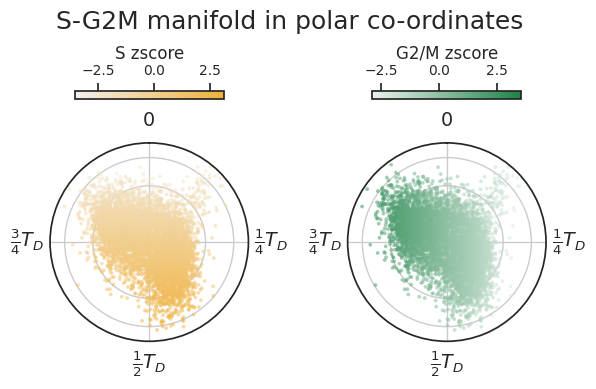

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, subplot_kw={"projection": "polar"}, 
                               gridspec_kw={'wspace':0.5},)

cmap1 = sns.light_palette(yellow, as_cmap=True)
v1min, v1max = s_zscore.min(), s_zscore.max()
norm1 = Normalize(vmin=v1min, vmax=v1max)  

cmap2 = sns.light_palette(green, as_cmap=True)   #
v2min, v2max = g2m_zscore.min(), g2m_zscore.max()
norm2 = Normalize(vmin=v2min, vmax=v2max)  

sns.scatterplot(x=2*np.pi*phi, y=r, lw=0, alpha=0.5, s=7.5, hue=s_zscore, 
                palette=cmap1, hue_norm=norm1,  legend=False, ax=ax1)
sns.scatterplot(x=2*np.pi*phi, y=r, lw=0, alpha=0.5, s=7.5, hue=g2m_zscore, 
                palette=cmap2, hue_norm=norm2, legend=False, ax=ax2)

sm1 = plt.cm.ScalarMappable(cmap=cmap1, norm=norm1)
sm1.set_array([])
cb1 = plt.colorbar(sm1, ax=ax1, shrink=0.75, pad=0.12, 
                  orientation='horizontal', location='top')
cb1.set_label("S zscore", fontsize=12)
cb1.ax.tick_params(labelsize=10)
sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
cb2 = plt.colorbar(sm2, ax=ax2, shrink=0.75, pad=0.12, 
                  orientation='horizontal', location='top')
cb2.set_label("G2/M zscore", fontsize=12)
cb2.ax.tick_params(labelsize=10)

p99 = np.percentile(r, 99.9)
for ax in [ax1, ax2]:
    ax.set_theta_direction(-1)          # make theta increase clockwise
    ax.set_theta_zero_location("N")     # 0 along +x (to the right)
    ax.set_ylim(0, p99 )
    ax.set_yticks(np.arange(0, p99), ['']*len(np.arange(0, p99)))
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2], 
                  ['0', r'$\frac{1}{4}T_{D}$', r'$\frac{1}{2}T_{D}$', r'$\frac{3}{4}T_{D}$'])
fig.suptitle('S-G2M manifold in polar co-ordinates', y=0.95)    
plt.show()

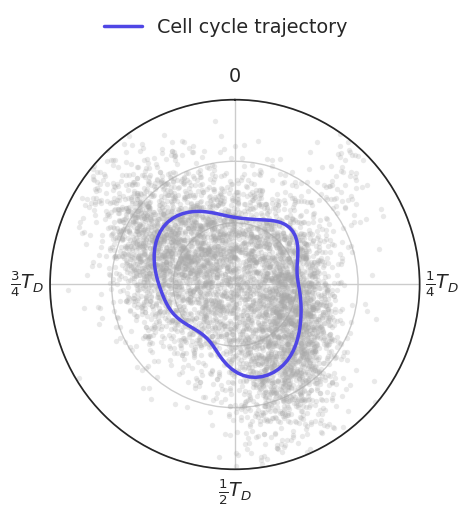

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
psm, rsm = utils.kernel_smooth_periodic(x=phi, y=r, fwhm=0.5, num_pts=100)
sns.scatterplot(x=phi*(2*np.pi), y=r, lw=0, s=15, alpha=0.25,  color='darkgrey')
sns.lineplot(x=psm*2*np.pi, y=rsm, lw=2.5, color=purple, label='Cell cycle trajectory' )

ax.set_theta_direction(-1)          # make theta increase clockwise
ax.set_theta_zero_location("N") 
ax.set_ylim(0, np.percentile(r, 99))
ax.set_yticks(np.arange(0, p99), ['']*len(np.arange(0, p99)))
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2], 
              ['0', r'$\frac{1}{4}T_{D}$', r'$\frac{1}{2}T_{D}$', r'$\frac{3}{4}T_{D}$'])
plt.legend(loc=(0.125, 1.15), frameon=False)
plt.show()

In [8]:
adata.obs['theta_init'] = utils.estimate_theta(x=s_zscore, y=g2m_zscore)
dfgex = pd.DataFrame(data=adata.X.toarray(), columns=adata.var.index, index=adata.obs.index)
dfgex = (dfgex - dfgex.mean(axis=0)).copy()

### Filter cycling genes based on explained variance and fold-change in amplitude over baseline

In [9]:
expvar_cutoff, ampfc_cutoff = 0.07, 0.015
thetasm, GEXsm = utils.kernel_smooth_periodic_torch(x=adata.obs['theta_init'].values, Y=X.toarray(), fwhm=0.5, num_pts=100)
Expvar, AmpFC = utils.explained_variance_torch(theta=adata.obs['theta_init'].values, GEX=X.toarray(), fwhm=0.5, num_pts=100)
expvar_genes = np.asarray(dfgex.columns[np.where(Expvar.detach().cpu().numpy()>expvar_cutoff)[0]])
ampfc_genes  = np.asarray(dfgex.columns[np.where(AmpFC.detach().cpu().numpy()>ampfc_cutoff)[0]])
ciclopes_genes = np.asarray(sorted(list(set(expvar_genes).union(set(ampfc_genes)))))
print(f"{len(ciclopes_genes)} genes satifiy the explained variance > {expvar_cutoff} OR fold-change in amplitude > {ampfc_cutoff}." )

420 genes satifiy the explained variance > 0.07 OR fold-change in amplitude > 0.015.


### Load $\theta_{\mathsf{init}}$ and normalized mean-centered gene exprssion as tensor objects

In [10]:
theta_init = torch.tensor(adata.obs['theta_init'].values, dtype=torch.float32, device='cuda')
Ecg = torch.tensor(dfgex[ciclopes_genes].values, dtype=torch.float32, device='cuda')

### Train-test split

In [11]:
test_size = 0.25
batch_size = 128
E_train, E_test, theta_train, theta_test = train_test_split(Ecg, theta_init, test_size=0.2)
train_dataset = TensorDataset(E_train, theta_train)
test_dataset  = TensorDataset(E_test, theta_test)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Optimize Fourier coefficients of the genes

In [12]:
num_epochs = 2000
learn_rate = 1e-4
gex_model = Ciclopes(Ecg)
gex_model = gex_model.to(device) 
optimizer1 = torch.optim.AdamW([p for p in [gex_model.Creal, gex_model.Cimag]], lr=learn_rate)

train_loss = []
test_loss = []

for ep in range(num_epochs+1):
    gex_model.train()
    for X, theta in train_loader:
        X, theta = X.to(device), theta.to(device)
        optimizer1.zero_grad(set_to_none=True)
        Xm = gex_model.GEXmodel(theta)
        loss = gex_model.Loss(X, Xm)
        loss.backward()
        optimizer1.step()
    
    Em = gex_model.GEXmodel(theta_train)
    loss = gex_model.Loss(E_train, Em)
    train_loss.append(loss.item() / E_train.shape[0])

    Em = gex_model.GEXmodel(theta_test)
    loss = gex_model.Loss(E_test, Em)
    test_loss.append(loss.item() / E_test.shape[0])
    
    dfls = pd.DataFrame(list(zip(np.arange(len(train_loss)), train_loss, test_loss)),
                      columns=['epoch', 'train_loss', 'test_loss'])
    if ep % 500==0:
        print(f'epoch = {ep}\t train loss =  {train_loss[-1]:.2f}\t test loss = {test_loss[-1]:.2f}')

epoch = 0	 train loss =  418.26	 test loss = 418.36
epoch = 500	 train loss =  -359.08	 test loss = -359.18
epoch = 1000	 train loss =  -402.44	 test loss = -402.57
epoch = 1500	 train loss =  -402.43	 test loss = -402.60
epoch = 2000	 train loss =  -402.44	 test loss = -402.59


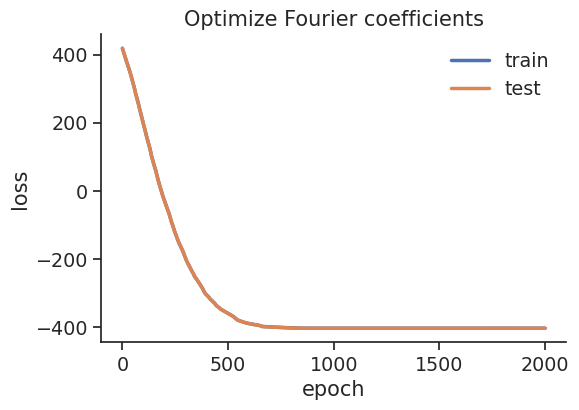

In [13]:
plt.figure(figsize=(6, 4))
ax = plt.gca()
sns.lineplot(data=dfls, x='epoch', y='train_loss', lw=2.5, label='train')
sns.lineplot(data=dfls, x='epoch', y='test_loss',  lw=2.5, label='test')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.title('Optimize Fourier coefficients')
ax.legend(frameon=False)
sns.despine()

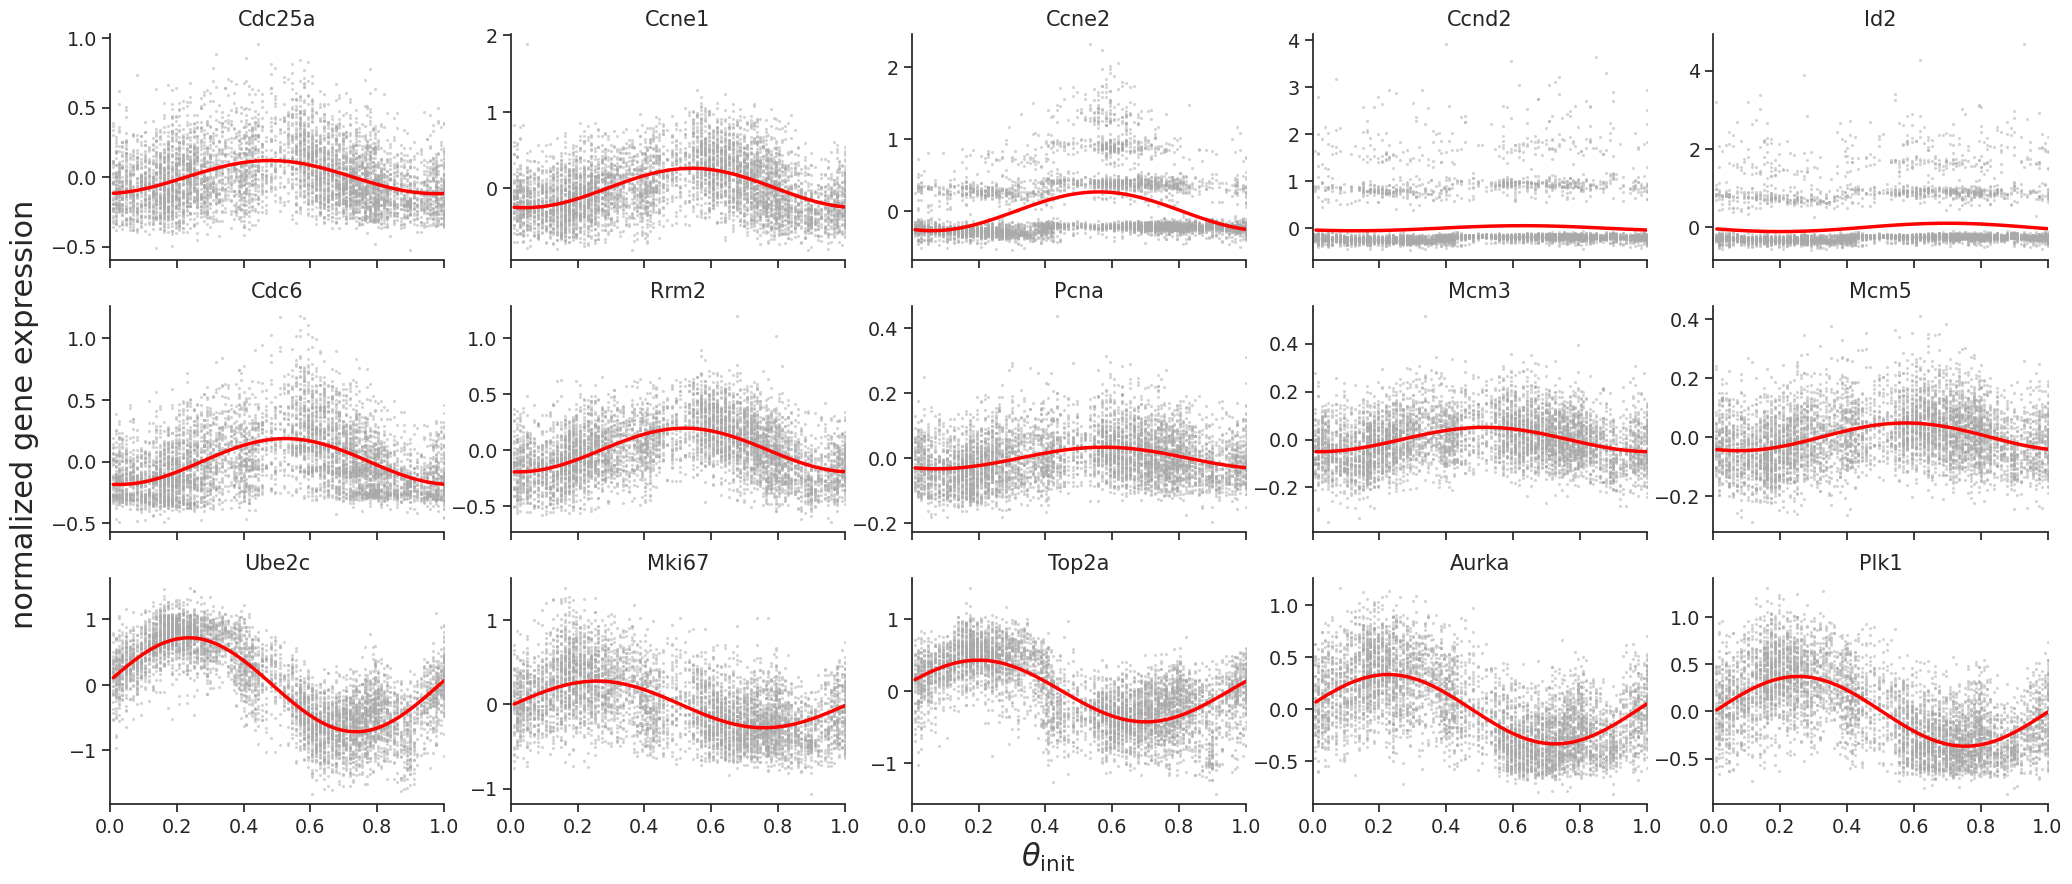

In [14]:
theta_mod = np.linspace(0.01, 1, 100)
Em = gex_model.GEXmodel(torch.tensor(theta_mod, dtype=torch.float32, device=device))

plot_genes = ['Cdc25a', 'Ccne1', 'Ccne2', 'Ccnd2', 'Id2', 
              'Cdc6', 'Rrm2', 'Pcna', 'Mcm3', 'Mcm5',  
              'Ube2c', 'Mki67', 'Top2a', 'Aurka', 'Plk1']

fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(25, 10), sharex=True)
for ax, gene in zip(axs.flatten(), plot_genes):
    gindx = np.where(np.asarray(ciclopes_genes)==gene)[0][0]
    sns.scatterplot(x=theta_init.detach().cpu().numpy(), y=dfgex[ciclopes_genes][gene], color ='darkgrey' ,lw=0, s=5, alpha=0.5, ax=ax)
    sns.lineplot(x=theta_mod, y=Em.detach().cpu().numpy()[gindx], lw=2.5, color='red', ax=ax)
    ax.set_ylabel('')
    ax.set_title(gene)
    ax.set_xlim(0,1)
fig.supxlabel(r'$\theta_\mathsf{init}$', y=0.04, fontsize=22)
fig.supylabel(r'normalized gene expression', x=0.085, fontsize=22)    
sns.despine()

### Optimize neural network parameters 

In [15]:
num_epochs = 500
learn_rate = 1e-4
phase_model = Ciclopes(Ecg, coeffs=(gex_model.Creal, gex_model.Cimag))   
phase_model = phase_model.to(device)
# proper init
with torch.no_grad():
    for m in phase_model.Encoder.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
            nn.init.constant_(m.bias, 1e-6)
for p in [phase_model.Creal, phase_model.Cimag]:
    if isinstance(p, nn.Parameter):
        p.requires_grad = False
optimizer2 = torch.optim.AdamW(phase_model.Encoder.parameters(), lr=learn_rate)

train_loss = []
test_loss = []
for ep in range(num_epochs+1):
    phase_model.train()
    for X, theta in train_loader:
        X, theta = X.to(device), theta.to(device)
        optimizer2.zero_grad(set_to_none=True)
        theta, Xm = phase_model.Forward(X)
        loss = phase_model.Loss(X, Xm)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(phase_model.Encoder.parameters(), 1.0)
        optimizer2.step()
    
    theta, Em = phase_model.Forward(E_train)
    loss = phase_model.Loss(E_train, Em)
    train_loss.append(loss.item() / E_train.shape[0])

    theta, Em = phase_model.Forward(E_test)
    loss = phase_model.Loss(E_test, Em)
    test_loss.append(loss.item() / E_test.shape[0])
    
    dfls = pd.DataFrame(list(zip(np.arange(len(train_loss)), train_loss, test_loss)),
                      columns=['epoch', 'train_loss', 'test_loss'])
    if ep % 500==0:
        print(f'epoch = {ep}\t train loss =  {train_loss[-1]:.2f}\t test loss = {test_loss[-1]:.2f}')

epoch = 0	 train loss =  -391.48	 test loss = -391.78
epoch = 500	 train loss =  -408.92	 test loss = -409.10


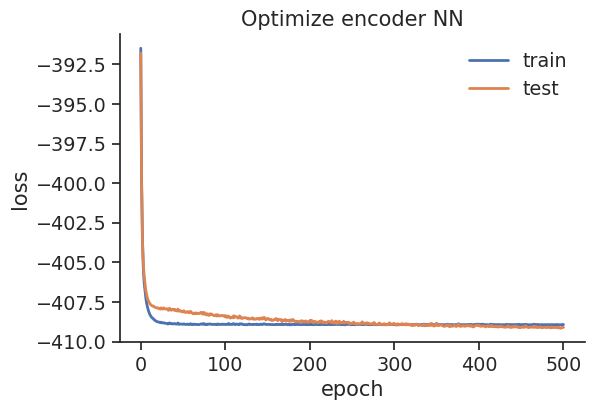

In [16]:
plt.figure(figsize=(6, 4))
ax = plt.gca()
sns.lineplot(data=dfls, x='epoch', y='train_loss', lw=2, label='train')
sns.lineplot(data=dfls, x='epoch', y='test_loss',  lw=2, label='test')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.title('Optimize encoder NN')
ax.legend(frameon=False)
sns.despine()

### Identification of M $\rightarrow$ G1 boundary ($\theta_{\mathsf{shift}}$)

M -> G1 boundary = 0.44


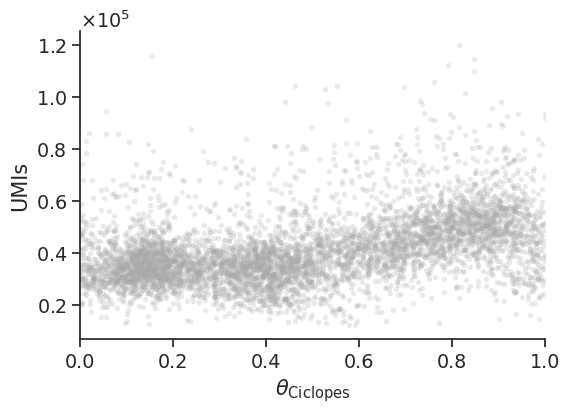

In [17]:
thetaCic, Em = phase_model.Forward(Ecg)
adata.obs['thetaCic'] = thetaCic.detach().cpu().numpy()
y, x, maxtheta0, theta0, error = phase_transistions.fit_m_to_g1_transition(adata)
tshift = round (1 - maxtheta0, 2)

print (f"M -> G1 boundary = %s"%tshift)
plt.figure(figsize=(6, 4))
sns.scatterplot(x=[(t-tshift)%1 for t in adata.obs['thetaCic']], y=adata.obs['n_counts'], lw=0, s=15, alpha=0.25, color='darkgrey')
plt.ticklabel_format(axis='y',style='sci', scilimits=(0,1), useMathText=True)
plt.xlim([0,1])
plt.xlabel(r'$\theta_{\mathsf{Ciclopes}}$')
plt.ylabel('UMIs')
sns.despine()

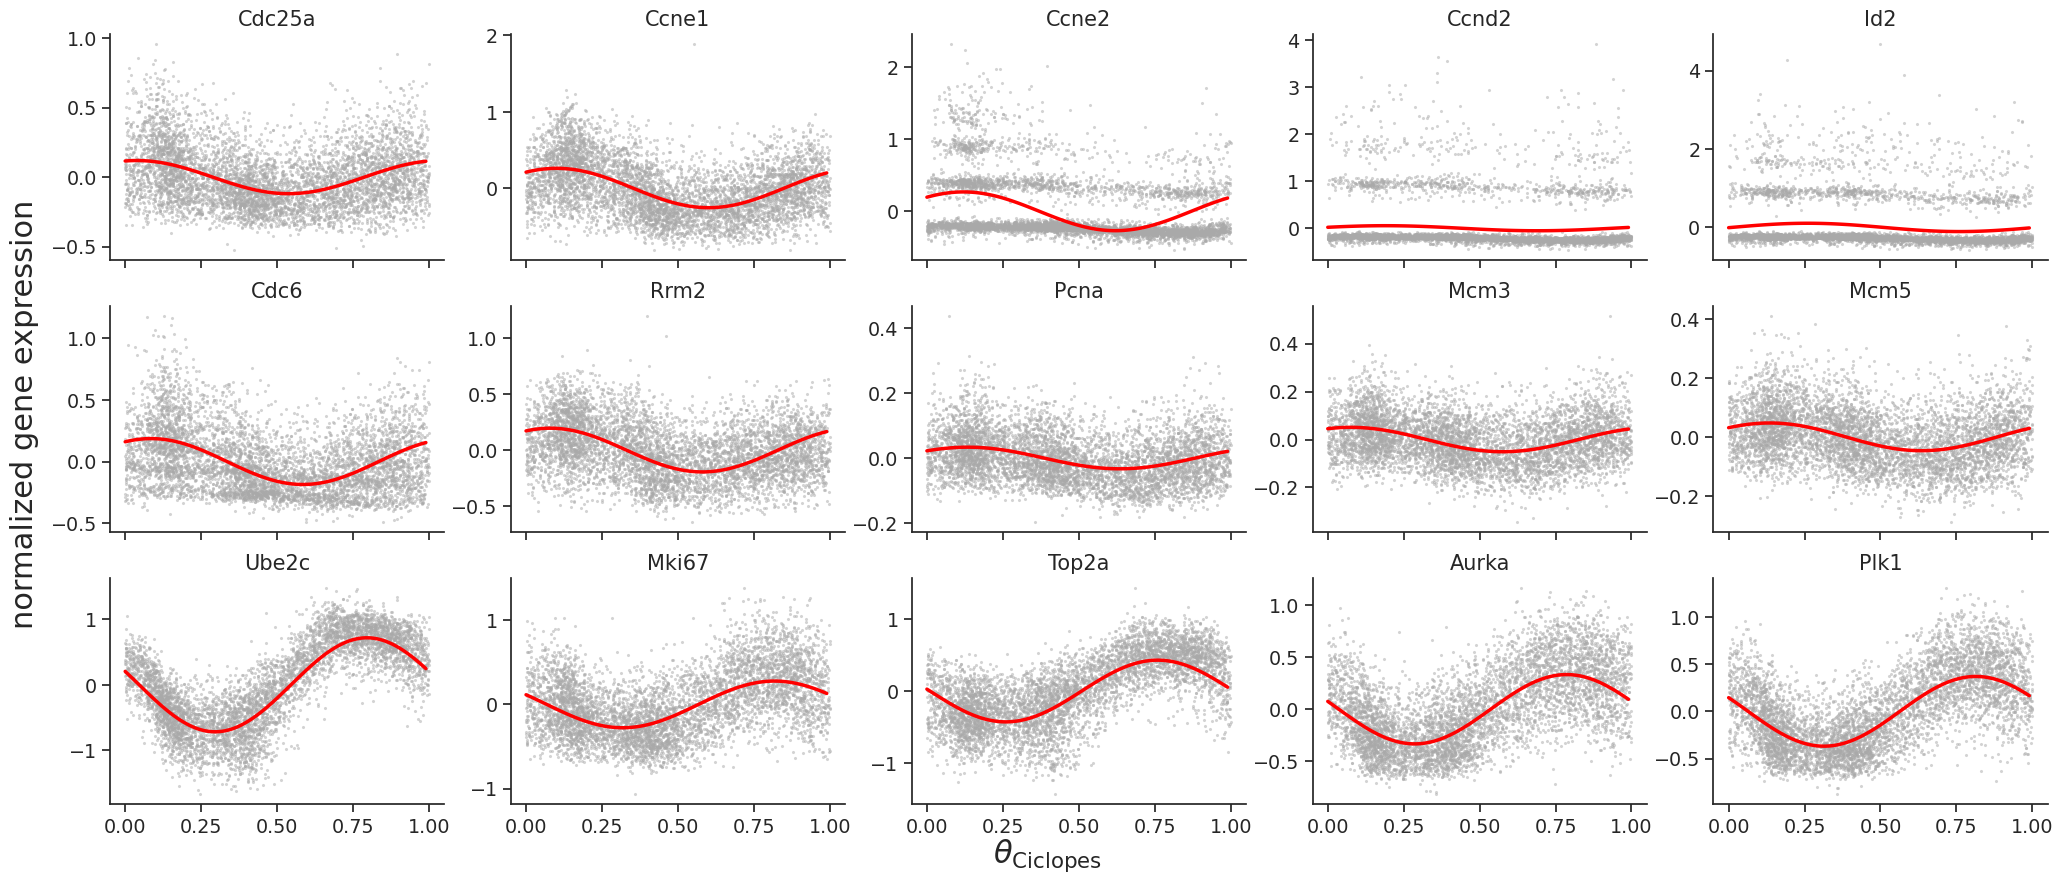

In [18]:
Em = phase_model.GEXmodel(torch.tensor(theta_mod, dtype=torch.float32).to(device))
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(25, 10), sharex=True)
for ax, gene in zip(axs.flatten(), plot_genes):
        gindx = np.where(np.asarray(ciclopes_genes)==gene)[0][0]
        sns.scatterplot(x=[(t-tshift)%1 for t in adata.obs['thetaCic']], y=dfgex[ciclopes_genes][gene], color ='darkgrey' ,lw=0, s=5, alpha=0.5, ax=ax)
        sns.lineplot(x=[(t-tshift)%1 for t in theta_mod], y=Em.detach().cpu().numpy()[gindx], lw=2.5, color='red', ax=ax)
        ax.set_ylabel('')
        ax.set_title(gene)

fig.supxlabel(r'$\theta_\mathsf{Ciclopes}$', y=0.04, fontsize=22)
fig.supylabel(r'normalized gene expression', x=0.085, fontsize=22)    
sns.despine()

### Load DeeplCycle data for comparison

In [19]:
tshift_DC = 0.89
adata_deep = anndata.read_h5ad('/shared/space2/molina/Data/mESCs_2iLIF/SRR13790993/deepcycle/deepcycle.h5ad')
adata_deep.obs['cell_cycle_theta'] = [(t-tshift_DC)%1 for t in adata_deep.obs['cell_cycle_theta'].values]
dftheta = pd.DataFrame(adata_deep.obs['cell_cycle_theta'])
dftheta.columns = ['thetaDC']
dftheta.index = [cid.split(':')[-1]for cid in dftheta.index]
adata.obs = pd.concat([adata.obs, dftheta],axis=1)

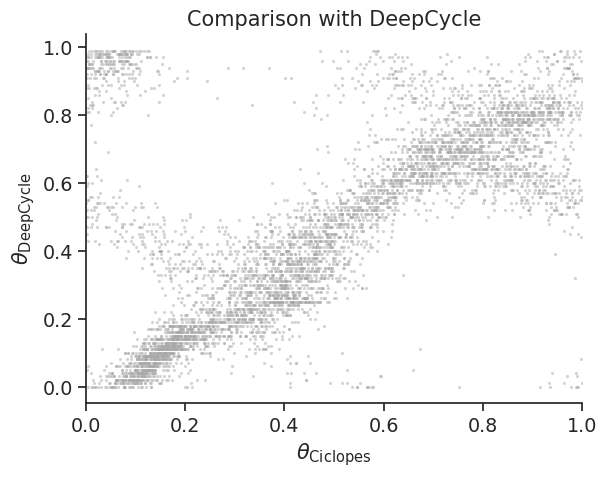

In [20]:
sns.scatterplot(x=[(t-tshift)%1 for t in adata.obs['thetaCic']], y=adata.obs['thetaDC'], color='darkgrey', lw=0, s=5, alpha=0.5)
plt.xlabel(r'$\theta_{\mathsf{Ciclopes}}$')
plt.ylabel(r'$\theta_{\mathsf{DeepCycle}}$')
plt.title ("Comparison with DeepCycle")
plt.xlim([0,1])
sns.despine()

In [21]:
adata.obs['thetaDC']

AAACCCAAGTCGGCCTx    0.38
AAACCCACACCCTAAAx    0.47
AAACCCACACGAAAGCx    0.50
AAACCCACACTCAGATx    0.79
AAACCCACAGAGCCCTx    0.37
                     ... 
TTTGTTGCATTCTCCGx    0.11
TTTGTTGGTGGACCTCx    0.90
TTTGTTGGTGGCACTCx    0.37
TTTGTTGTCGCCAATAx    0.81
TTTGTTGTCTTGCGCTx    0.67
Name: thetaDC, Length: 5683, dtype: float64